https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
The data (last updated 11/10/2017) is presented in CSV format as follows: Date, Open, High, Low, Close, Volume, OpenInt. Note that prices have been adjusted for dividends and splits.




In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [5]:
df = pd.read_csv('aapl.us.txt', parse_dates=["Date"])

In [6]:
df.shape

(8364, 7)

In [7]:
df.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [8]:
df["Date"].min(), df["Date"].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

<AxesSubplot:xlabel='Date'>

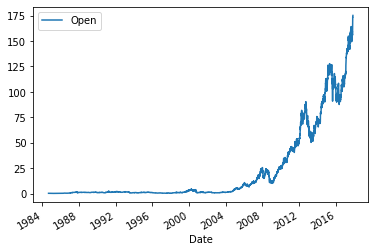

In [9]:
df.plot(x="Date", y="Open")

<AxesSubplot:xlabel='Date'>

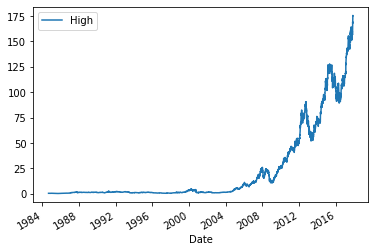

In [10]:
df.plot(x="Date", y="High")

Попарная корееляция между всеми ценами. Корреляция мера между двумя векторами, принимающая значения от -1 до 1.

In [13]:
df[['Open', 'Close', 'Low', 'High']].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


Для предсказания цены будут использованы данные за 6 лет. Дата распаршена, поэтому из максимальной вычитаем timedelta. 


In [14]:
df_6_yr = df[df["Date"] > df["Date"].max() - timedelta(days=365 * 6)]

In [15]:
df_6_yr.shape

(1509, 7)

In [16]:
df_6_yr["Date"].min(), df_6_yr["Date"].max()

(Timestamp('2011-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

Данные представляют временной ряд. Важно, чтобы события из валидационного сета шли позже тренировочного, чтобы модель не знала будущего и не было лика. 80% пойдут в тренировочный сет 

In [18]:
train_size = int(df_6_yr.shape[0] * 0.8)
train_df = df_6_yr.iloc[:train_size]
val_df = df_6_yr.iloc[train_size:]

In [19]:
train_df.shape, val_df.shape 

((1207, 7), (302, 7))

In [20]:
train_df["Date"].min(), train_df["Date"].max(), val_df["Date"].min(), val_df["Date"].max()

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

Делаем датасет для временого ряда. Работа с минимальной ценой. Прошлое значение временого ряда будет использована как фича для предсказания следующего значения. Задача регрессии.

scaler - класс библиотеки skilearn, который используется для нормализации фичей. 

def make_dataset на вход принимает df, window_size - кол-во элементов временого ряда, которые будут использоваться для предсказания последующего элемента, batch_size - кол-во элементов в батче для обучения, use_scaler - скелер для нормализации фичей, shuffle - смеши вание элементов в ДС.

Для предсказания n+1 элемента будет использоваться n предыдущих как фичи. 

In [21]:
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])

def make_dataset(
    df,
     window_size, 
     batch_size,
     use_scaler=True,
     shuffle=True
     ):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return ds

In [22]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)

Получение элементов по одному 

In [23]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [24]:
example_feature.shape

(2, 3, 1)

In [25]:
example_label.shape

(2,)

In [26]:
train_df["Low"].iloc[:6]

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [27]:
print(example_feature[0])
print(example_label[0])

[[48.432]
 [48.592]
 [49.217]]
48.086


Делаем ДС для тренировочного и валидационного ДФ и обучаем модель.

In [28]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

Ниже код модели. Испольхуем класс Sequential, который создает модель в которой все слои будут выполняться последовательно. LSTM слой для рекурентной нейроной сети(указываем выходную размерность данных и последовательность при необходимости). Далее идет слой, который преобразует данный из размерности 32 в 1 тк нужно возвращать 1 элемент значения цены. Далее компеляция и обучение модели. 

In [29]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

Функция на вход принимает модель, тренировочный ДС, валидационный ДС и кол-во эпох для тренировки. 

In [30]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
  history = model.fit(
      train_ds, 
      epochs=num_epochs,
      validation_data=val_ds,
      verbose=0
      )
  return history

In [31]:
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

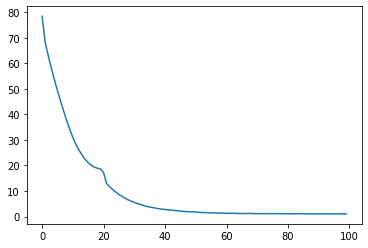

In [32]:
plt.plot(history.history['mean_absolute_error'])

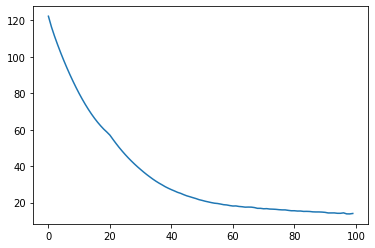

In [33]:
plt.plot(history.history['val_mean_absolute_error'])

In [34]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 2.7354 - mean_absolute_error: 1.2363


[2.73537278175354, 1.2363404035568237]

In [35]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 321.0409 - mean_absolute_error: 14.0182


[321.0408630371094, 14.018173217773438]

Попробуем увеличить количество эпох и посмотреть на результат. 

In [36]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)

In [37]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 1.8339 - mean_absolute_error: 0.9420


[1.833854079246521, 0.942043125629425]

In [38]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 195.9997 - mean_absolute_error: 11.0996


[195.99966430664062, 11.099587440490723]

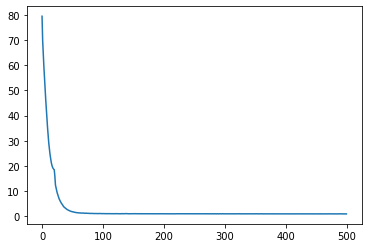

In [39]:
plt.plot(history.history['mean_absolute_error'])

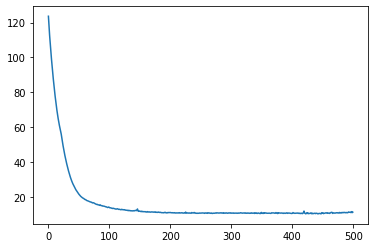

In [40]:
plt.plot(history.history['val_mean_absolute_error'])

Значения для тренировочного ДС уменьшилось, но и для валидационного. Возможно произошло переобучение. Далее будут использованы методы регуляризации, например Dropout. Для этого добавляем еще один слой.  

In [41]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)

In [42]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 4.1480 - mean_absolute_error: 1.6073


[4.14796257019043, 1.6072725057601929]

In [43]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 74.0466 - mean_absolute_error: 7.1465


[74.04663848876953, 7.146485328674316]

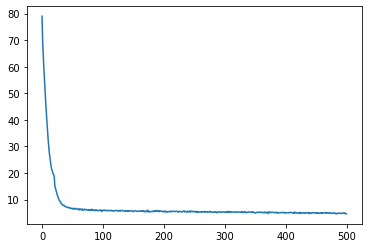

In [44]:
plt.plot(history.history['mean_absolute_error'])

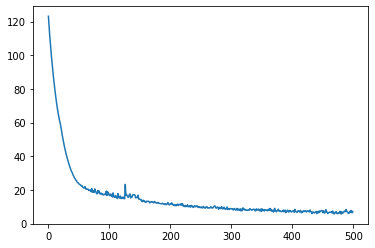

In [45]:
plt.plot(history.history['val_mean_absolute_error'])

orderbook lstm analysis PDF с номером 8289864